In [50]:
import os

DIR = "data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    directories.append({'name': folder, 'photos': len(photos)})
    
directories.sort(key=lambda x: x['photos'], reverse=True)

In [98]:
import os

DIR = "data/fungi_train_val"
filelist = []

cat = os.listdir(DIR)
n_categories = 50
training_size = 0.8

for i in range(n_categories):
    img = os.listdir(DIR + "/" + directories[i]['name'])
    samples_per_class = 100
    train_images = int(min(len(img), samples_per_class)*training_size);
    for j in range(min(len(img), samples_per_class)):
        if j < train_images:
            filelist.append({
                'category': directories[i]['name'][directories[i]['name'].index('_')+1:].replace('_', ' '),
                'filename': img[j], 
                'path': DIR + "/" + directories[i]['name'] + "/" + img[j], 
                'training': 1})
        else:
            filelist.append({
                'category': directories[i]['name'][directories[i]['name'].index('_')+1:].replace('_', ' '),
                'filename': img[j], 
                'path': DIR + "/" + directories[i]['name'] + "/" + img[j], 
                'training': 0})
        
print("Categories:", n_categories)
print("Elements:", len(filelist))

Categories: 50
Elements: 5000


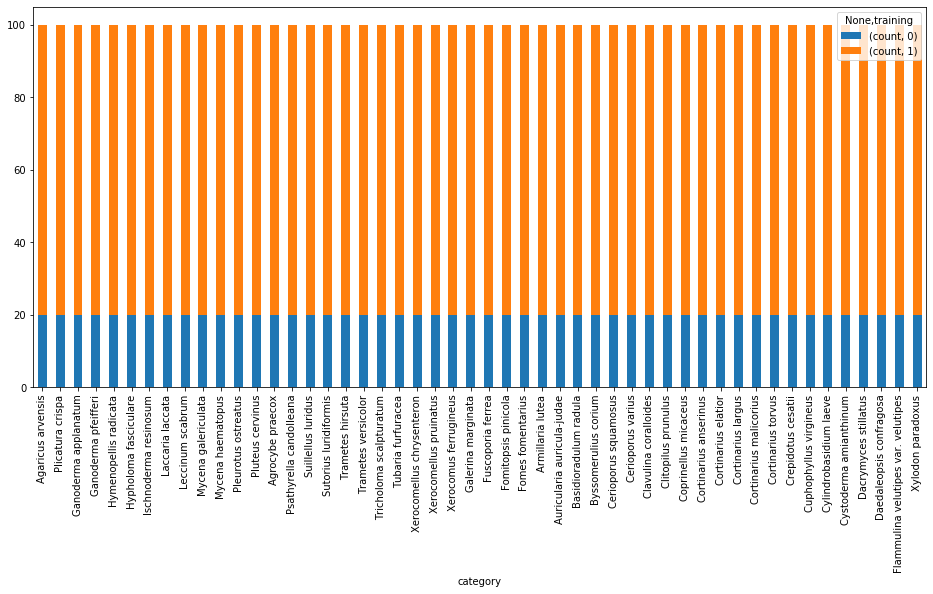

In [99]:
import pandas as pd

df = pd.DataFrame(filelist)
df_count = df.groupby(['category','training']).count().rename(columns={'filename':'count'})[['count']]
df_count = df_count.unstack('training').sort_values(by=[('count', 1)], ascending=False)
df_count.plot(kind='bar', stacked=True, figsize=(16,7))

In [100]:
training_set = list(filter(lambda x: x['training'] == 1, filelist))
validation_set = list(filter(lambda x: x['training'] == 0, filelist))

print("Training set:", len(training_set))
print("Validation set:", len(validation_set))

Training set: 4000
Validation set: 1000


In [101]:
df_training = df.loc[df['training'] == 1]
df_validation = df.loc[df['training'] == 0]

In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DIR = os.getcwd()
training_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

img_size = 150

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 4000 validated image filenames belonging to 50 classes.


In [103]:
validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 1000 validated image filenames belonging to 50 classes.


In [104]:
classes = [0 for i in range(max(validation_generator.classes)+1)]

for i in range(len(validation_generator.filenames)):
    cat = df.loc[df['path'] == validation_generator.filenames[i]]['category'].values[0]
    classes[validation_generator.classes[i]] = cat

print(classes)

['Agaricus arvensis', 'Agrocybe praecox', 'Armillaria lutea', 'Auricularia auricula-judae', 'Basidioradulum radula', 'Byssomerulius corium', 'Cerioporus squamosus', 'Cerioporus varius', 'Clavulina coralloides', 'Clitopilus prunulus', 'Coprinellus micaceus', 'Cortinarius anserinus', 'Cortinarius elatior', 'Cortinarius largus', 'Cortinarius malicorius', 'Cortinarius torvus', 'Crepidotus cesatii', 'Cuphophyllus virgineus', 'Cylindrobasidium laeve', 'Cystoderma amianthinum', 'Dacrymyces stillatus', 'Daedaleopsis confragosa', 'Flammulina velutipes var. velutipes', 'Fomes fomentarius', 'Fomitopsis pinicola', 'Fuscoporia ferrea', 'Galerina marginata', 'Ganoderma applanatum', 'Ganoderma pfeifferi', 'Hymenopellis radicata', 'Hypholoma fasciculare', 'Ischnoderma resinosum', 'Laccaria laccata', 'Leccinum scabrum', 'Mycena galericulata', 'Mycena haematopus', 'Pleurotus ostreatus', 'Plicatura crispa', 'Pluteus cervinus', 'Psathyrella candolleana', 'Suillellus luridus', 'Sutorius luridiformis', 'Tra

In [16]:
import tensorflow as tf

model = tf.keras.models.load_model('models/model_5classes_45acc_100x100img.h5')

In [113]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # Hidden layer
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(n_categories, activation='softmax')
])

In [114]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [109]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten

# VGG16
model = tf.keras.models.Sequential([
    Conv2D(input_shape=(img_size,img_size,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=n_categories, activation="softmax")
])

In [110]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 15, 15, 128)     

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(train_generator, epochs=100,
            validation_data = validation_generator,
            verbose=1, callbacks=[es])

model.save('model.h5')

Epoch 1/100
125/125 [==============================] - 258s 2s/step - loss: 3.9397 - accuracy: 0.0210 - val_loss: 3.8873 - val_accuracy: 0.0210
Epoch 2/100
125/125 [==============================] - 253s 2s/step - loss: 3.8727 - accuracy: 0.0275 - val_loss: 3.8388 - val_accuracy: 0.0630
Epoch 3/100
125/125 [==============================] - 254s 2s/step - loss: 3.7695 - accuracy: 0.0520 - val_loss: 3.7043 - val_accuracy: 0.0690
Epoch 4/100
125/125 [==============================] - 254s 2s/step - loss: 3.6720 - accuracy: 0.0707 - val_loss: 3.6676 - val_accuracy: 0.0730
Epoch 5/100
125/125 [==============================] - 255s 2s/step - loss: 3.6014 - accuracy: 0.0785 - val_loss: 3.5149 - val_accuracy: 0.1020
Epoch 6/100
125/125 [==============================] - 246s 2s/step - loss: 3.5562 - accuracy: 0.0967 - val_loss: 3.4156 - val_accuracy: 0.1240
Epoch 7/100
125/125 [==============================] - 199s 2s/step - loss: 3.5059 - accuracy: 0.0975 - val_loss: 3.4562 - val_accuracy:

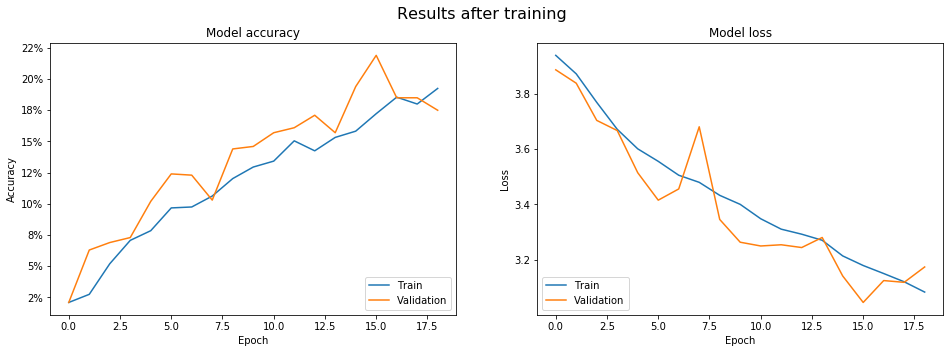

In [117]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Results after training', fontsize=16)

# summarize history for accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='lower left')

plt.show()

In [119]:
val_loss, val_acc = model.evaluate(validation_generator)

32/32 [==============================] - 12s 370ms/step - loss: 3.1839 - accuracy: 0.1740


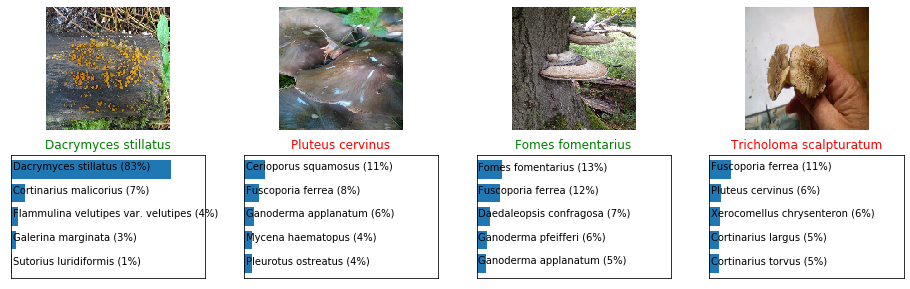

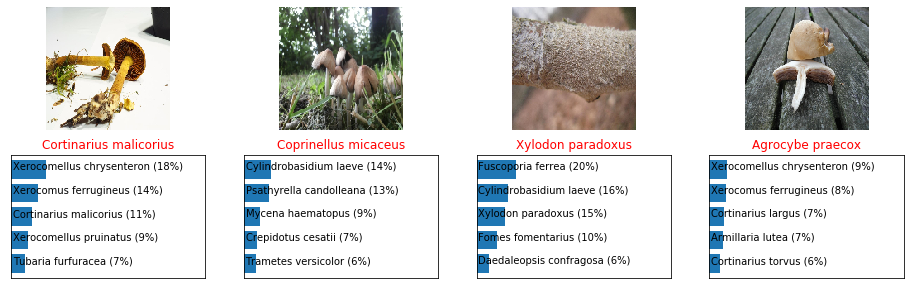

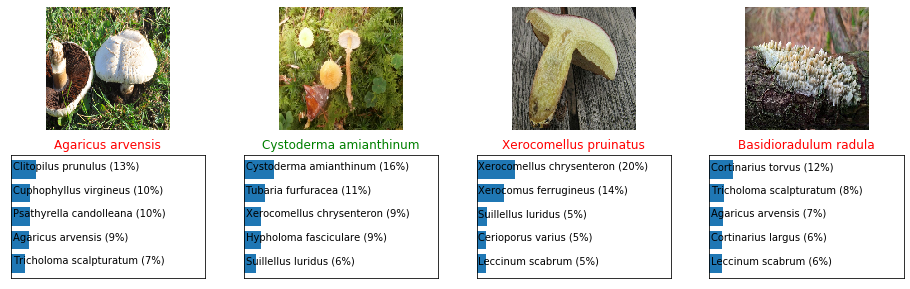

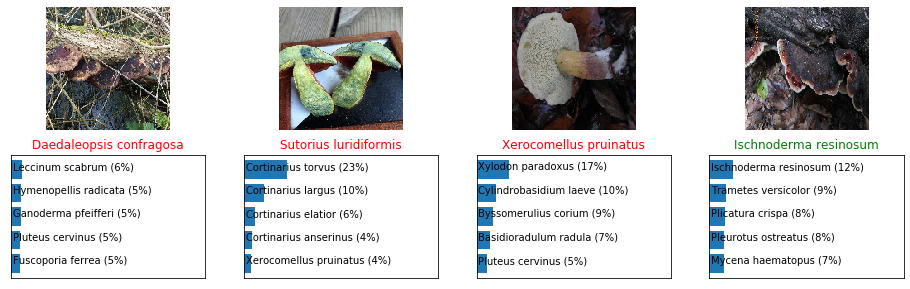

In [118]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FuncFormatter
import numpy as np

iters = 0
    
for i, batch in enumerate(validation_generator):
    if iters > 3:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > 3:
            break
            
        n_cols = 4
            
        fig, axes = plt.subplots(2, n_cols, figsize=(16,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k])
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))

        plt.show()
        
        iters += 1